# Effect of wider priors
In this notebook we will explore the effects of adopting less precise priors on the estimation of the key parameters of the SIR model given from simulated noisy data. We will use the same models defined in the `Inference_PyMC3` notebook.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
import theano

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Full SIR

In [3]:
data = np.load('logNSIRdata.npy')
data.shape

(80, 2)

In [4]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

In [5]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0, 20, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)


/usr/local/lib/python3.8/dist-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


### Forcing ${\cal R}_0 \geq 1$
For the following experiment we will double the Standard deviations of the priors compared to our previous experiment. 

In [24]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1.0)('R0', 2, 6)
    gam = pm.Lognormal('gamma', pm.math.log(2), 4)
    beta = pm.Deterministic('beta', gam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=data)
#     db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    

In [25]:
with model:
    trace = pm.sample(1000, tune=200, chains=2)
#     prior = pm.sample_prior_predictive()
#     posterior_predictive = pm.sample_posterior_predictive(trace)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if v.release[0] > 3 or v.release[1] >= 10:  # type: ignore
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma, R0, sigma]


/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 200 tune and 1_000 draw iterations (400 + 2_000 draws total) took 2772 seconds.
The acceptance probability does not match the target. It is 0.9127130635769783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9096898251541667, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


KeyboardInterrupt: 

In [26]:
pdata = az.from_pymc3(
    trace=trace,
    #prior=prior,
    #posterior_predictive=posterior_predictive
)

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


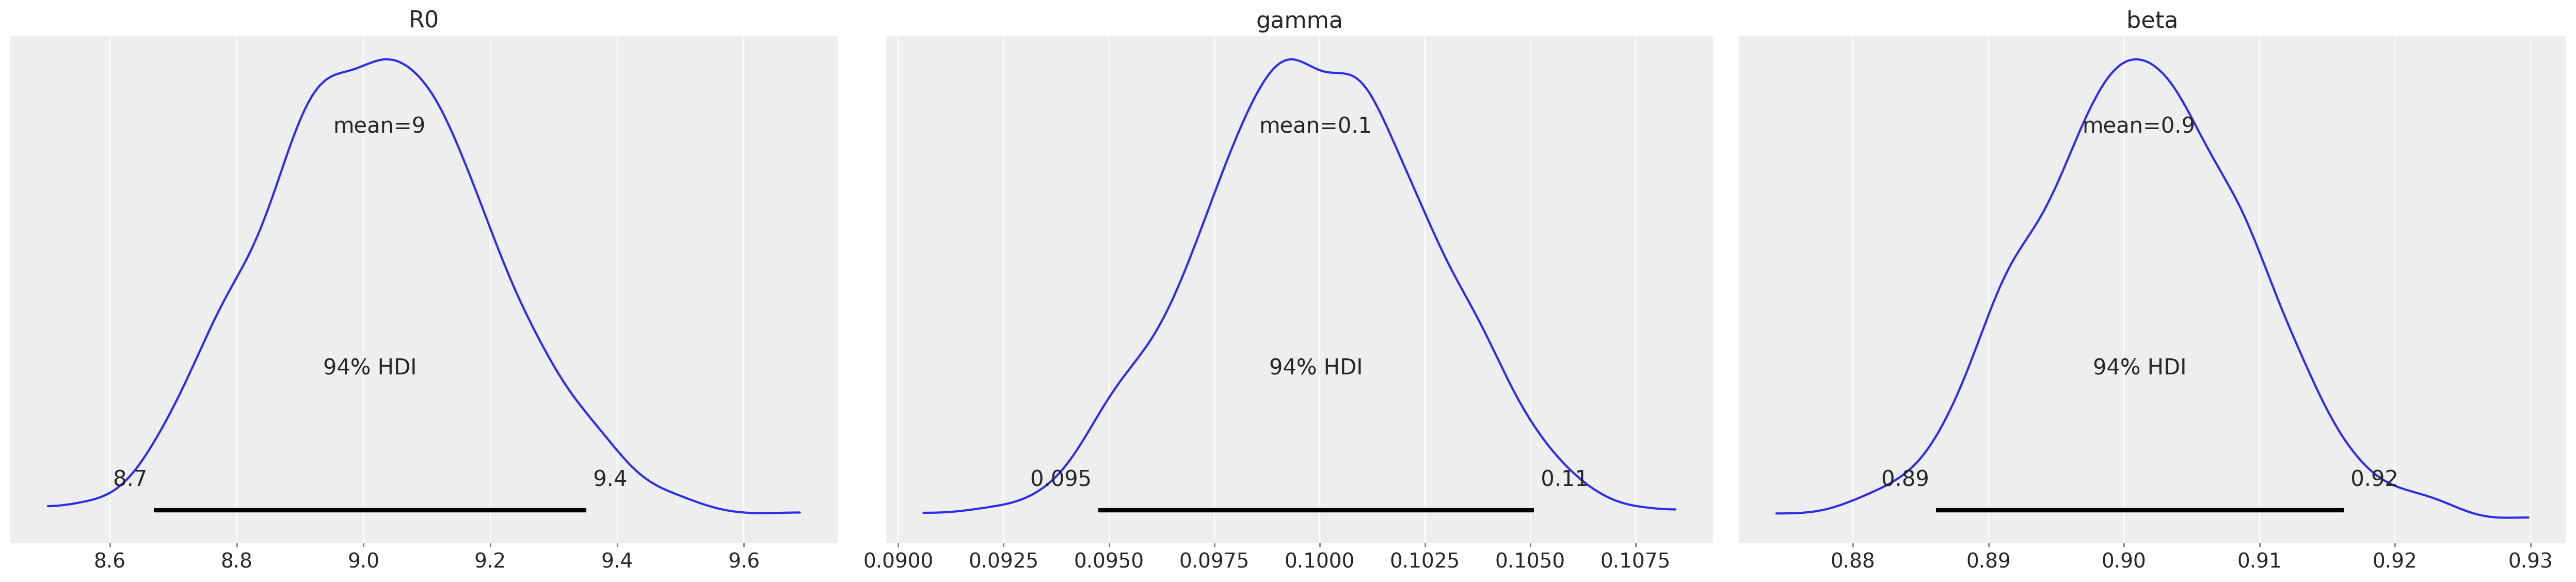

In [28]:
az.plot_posterior(pdata,var_names=['R0','gamma', 'beta']);

In [29]:
with model:
    vi = pm.fit(method='advi')

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sigma_log__`.ravel()[1] is NaN.
The current approximation of RV `R0_lowerbound__`.ravel()[0] is NaN.
The current approximation of RV `gamma_log__`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [ ]:
pm.plot_posterior(vi.sample(1000), color="LightSeaGreen");

### Letting $\beta$ and $\gamma$ vary independently

In [30]:
with pm.Model() as model2:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    gam = pm.Lognormal('gamma', pm.math.log(2), 4)
    beta = pm.Lognormal('beta', pm.math.log(4), 4)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=data)
#     db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    

In [31]:
with model2:
    trace2 = pm.sample(1000, tune=500, chains=2)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if v.release[0] > 3 or v.release[1] >= 10:  # type: ignore
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, gamma, sigma]


/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1467 seconds.
The acceptance probability does not match the target. It is 0.8947143205578115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018197547531033, but should be close to 0.8. Try to increase the number of tuning steps.


In [35]:
pdata2 = az.from_pymc3(
    trace=trace2,
    #prior=prior,
    #posterior_predictive=posterior_predictive
)

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


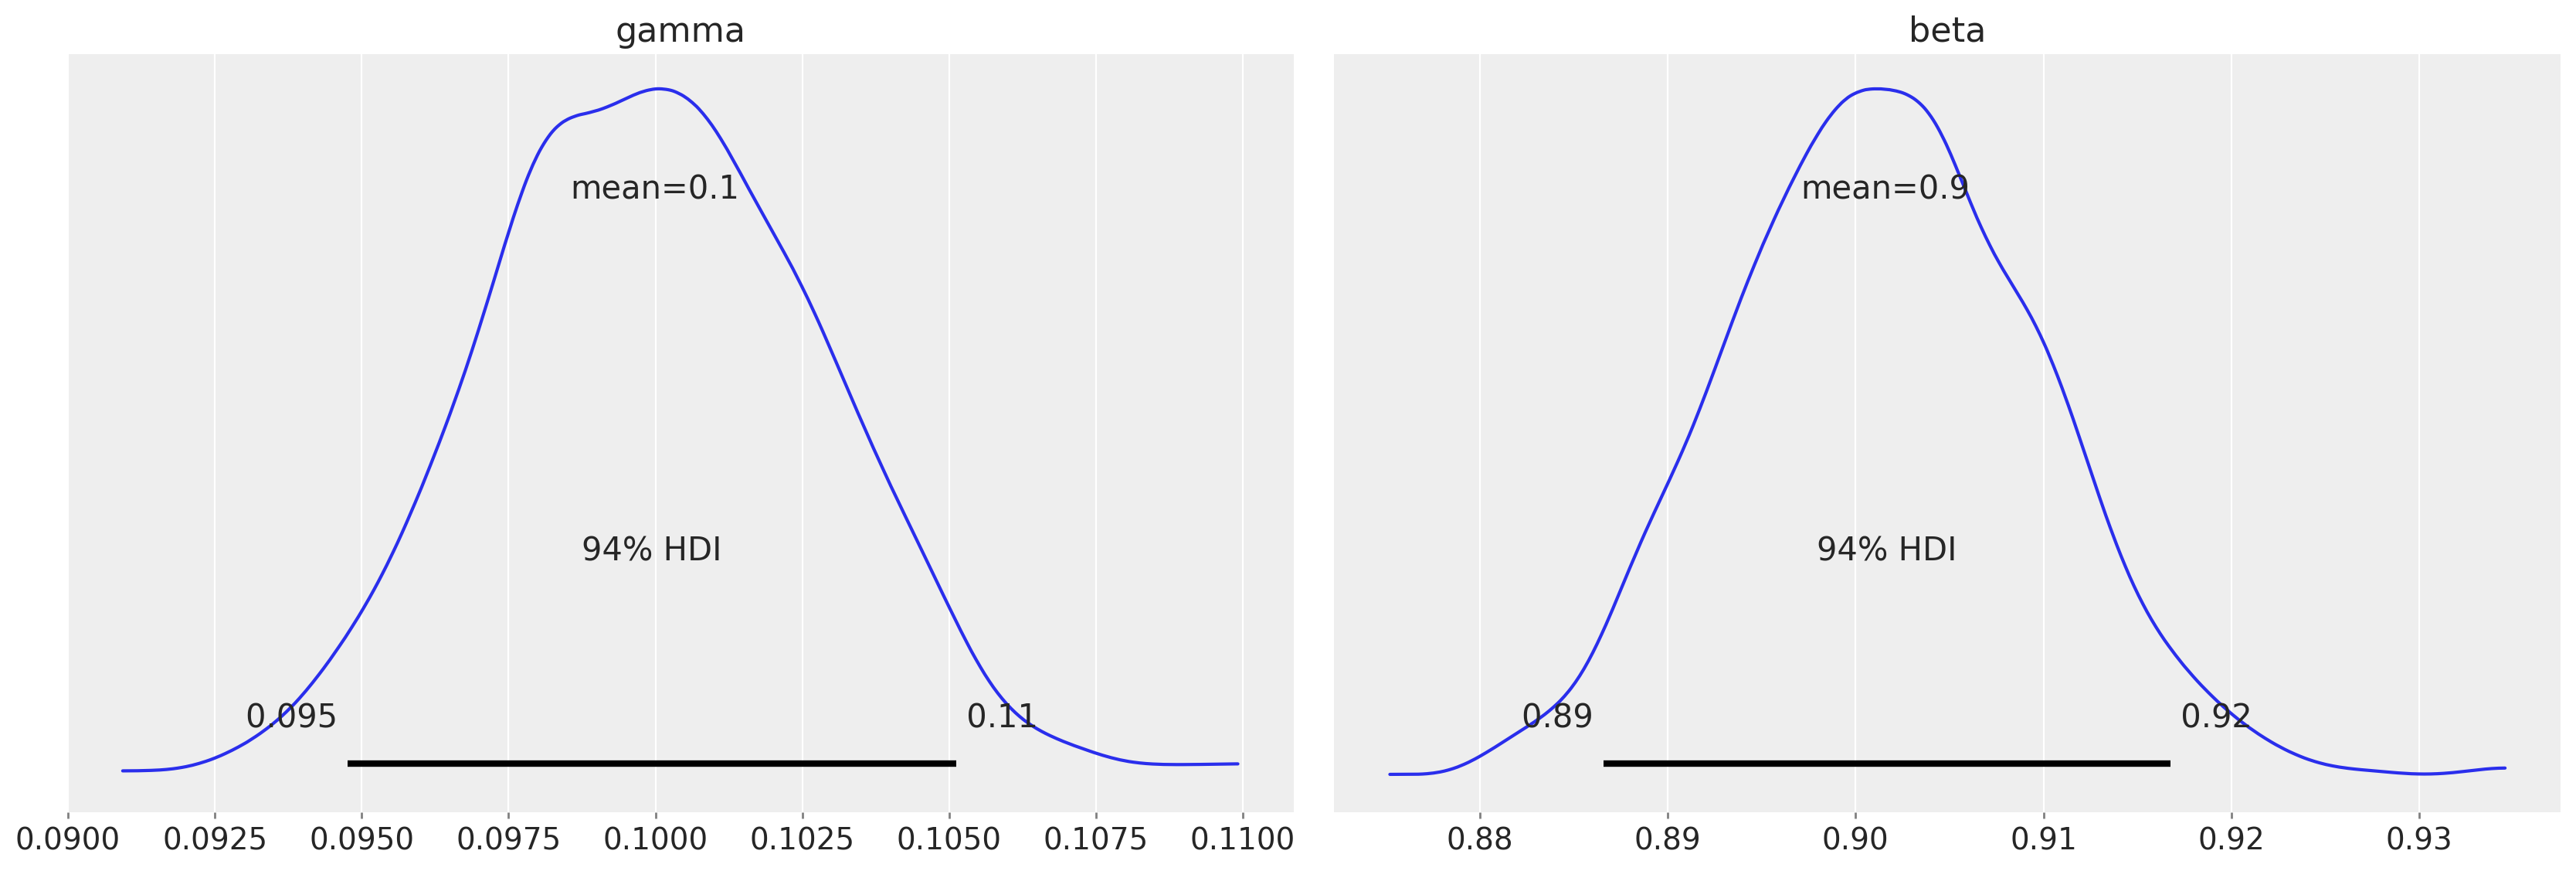

In [36]:
az.plot_posterior(pdata2,var_names=['gamma', 'beta']);

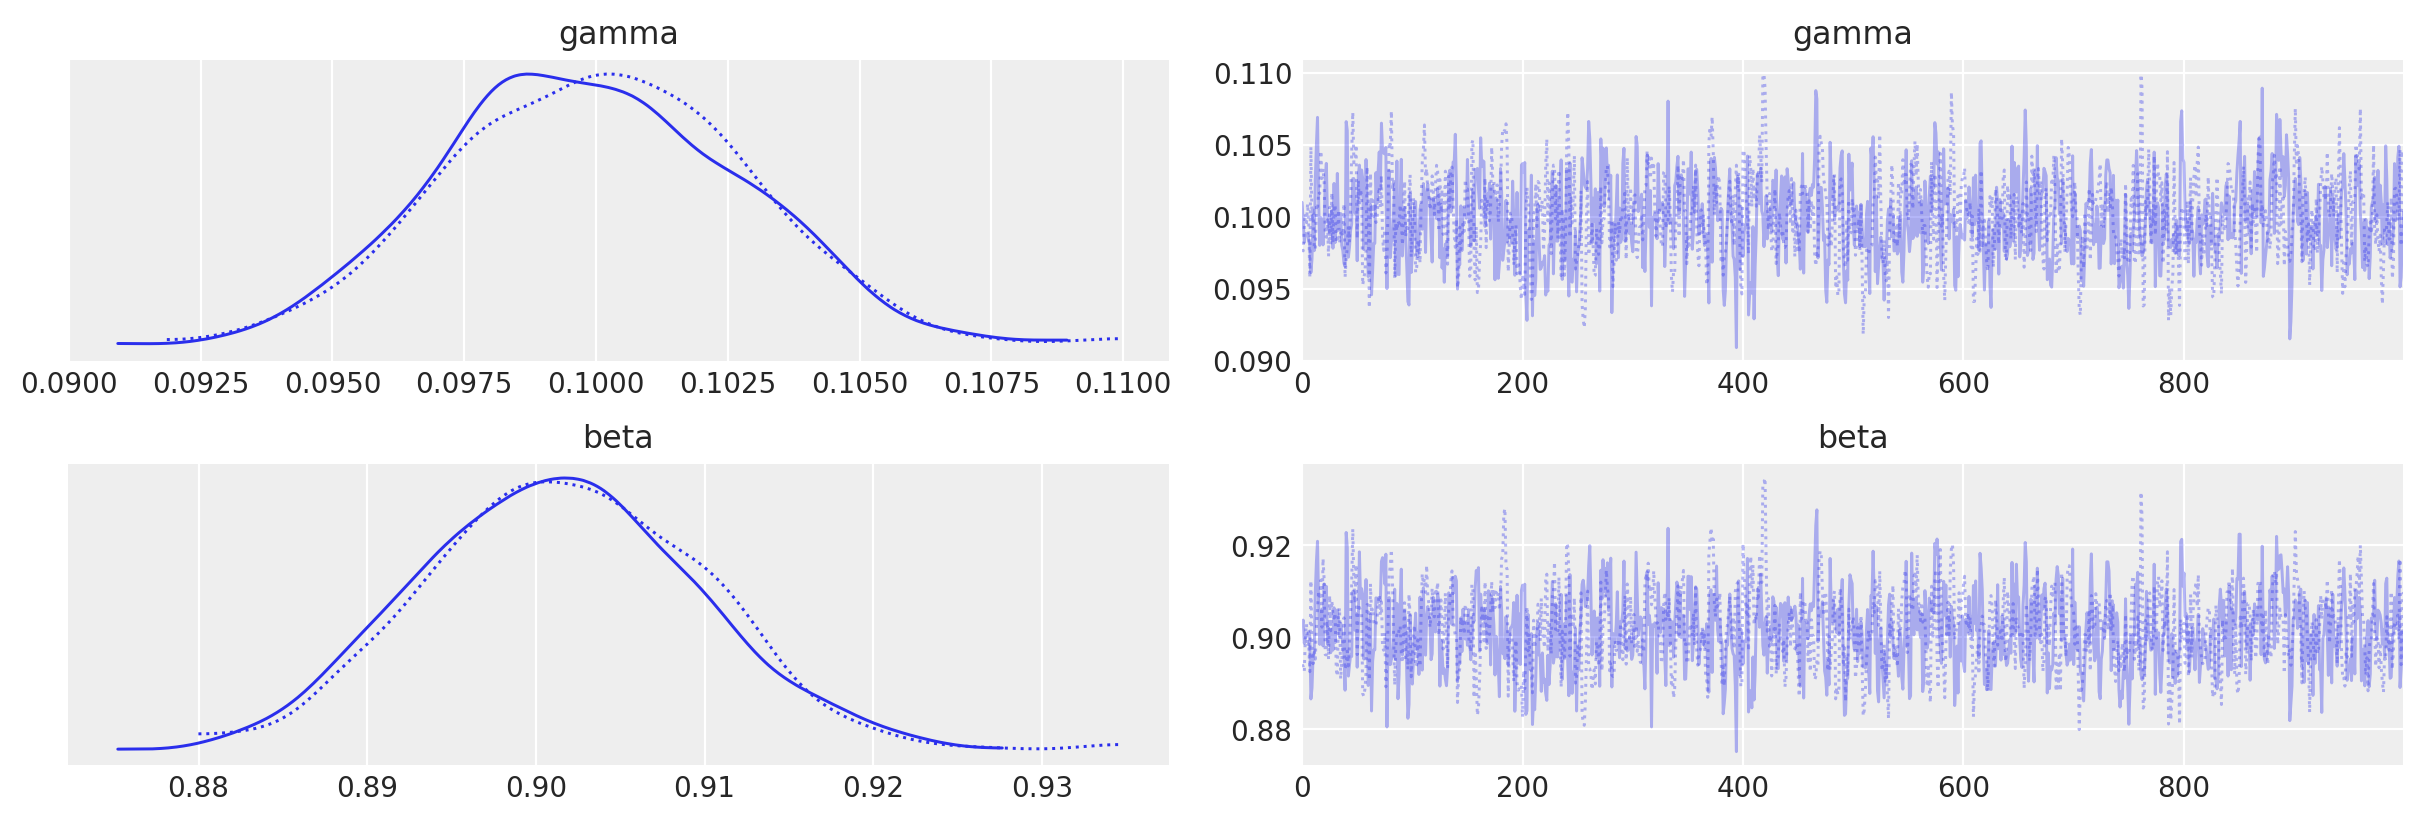

In [37]:
az.plot_trace(pdata2,var_names=['gamma', 'beta']);